In [5]:
# modified from test.ipynb and main.py

from matplotlib import pyplot as plt
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition

In [6]:
from loop import *

In [8]:
max_num_batteries = 20#200#25
num_batteries = DiscreteParameter(
    'num_batteries', [i for i in range(0, max_num_batteries)])
timsteps_per_week = 336
num_weeks = 1
time_horizon = DiscreteParameter(
    'time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])
parameter_space = ParameterSpace([num_batteries])
design = RandomDesign(parameter_space)

In [9]:
# battery_penalty = 735916.40/20
def f(X):
    """
    Handling API call to miniSCOT simulation given some inputs

    X contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]

    """
    Y = []
    for x in X:
        num_batteries = x[0]

        cum_reward = run_simulation(
            time_horizon=timsteps_per_week * num_weeks, num_batteries=num_batteries)#,battery_penalty=battery_penalty)

        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [5]:

# X = design.get_samples(num_data_points)
# Y = f(X)


In [6]:
# # emulator model
# use_default= False
# use_ard=True
# if use_default: 
#     gpy_model = GPRegression(X, Y)
# else: 
#     kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
#     gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
# gpy_model.optimize()
# model_emukit = GPyModelWrapper(gpy_model)

In [7]:
# # Load core elements for Bayesian optimization
# expected_improvement = ExpectedImprovement(model=model_emukit)
# optimizer = GradientAcquisitionOptimizer(space=parameter_space)

In [8]:
# # Create the Bayesian optimization object
# batch_size = 3
# bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
#                                          space=parameter_space,
#                                          acquisition=expected_improvement,
#                                          batch_size=batch_size)


In [9]:
# # Run the loop and extract the optimum;  we either complete 10 steps or converge
# max_iters = 10
# stopping_condition = FixedIterationsStoppingCondition(
#     i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)

# bayesopt_loop.run_loop(f, stopping_condition)

CURRENT ATTEMPT #0


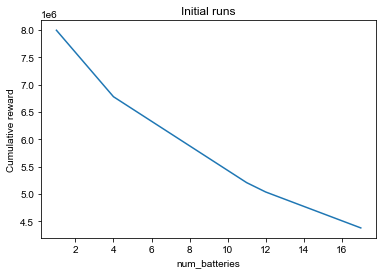

okay to optimize
successfully ran loop


In [10]:
# Initial set of batteries and associated reward of simulation
num_data_points = 5
successful_sample = False
num_tries = 0
max_num_tries = 3

use_default= False
use_ard=False

while not successful_sample and num_tries < max_num_tries: 
    
    print(f"CURRENT ATTEMPT #{num_tries}")
    
    X = design.get_samples(num_data_points)
    Y = f(X)
    
    # plot init values
    order = X.argsort(axis=0)
    init_X = X[order].flatten().reshape(-1, 1)
    init_Y = Y[order].flatten().reshape(-1, 1)
    plt.plot(init_X, init_Y)
    plt.style.use('seaborn')
    plt.title("Initial runs")
    plt.xlabel(parameter_space.parameters[0].name)
    plt.ylabel("Cumulative reward")
    plt.show()
    
    # emulator model

    if use_default: 
        gpy_model = GPRegression(X, Y)
    else: 
        kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
        gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
    
    try: 
        gpy_model.optimize()
        print("okay to optimize")
        model_emukit = GPyModelWrapper(gpy_model)

        # Load core elements for Bayesian optimization
        expected_improvement = ExpectedImprovement(model=model_emukit)
        optimizer = GradientAcquisitionOptimizer(space=parameter_space)

        # Create the Bayesian optimization object
        batch_size = 3
        bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                 space=parameter_space,
                                                 acquisition=expected_improvement,
                                                 batch_size=batch_size)

        # Run the loop and extract the optimum;  we either complete 10 steps or converge
        max_iters = 10
        stopping_condition = FixedIterationsStoppingCondition(
            i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)


        bayesopt_loop.run_loop(f, stopping_condition)
        print("successfully ran loop")
        successful_sample = True
        
    except: 
        num_tries += 1 
        



In [11]:
X,Y

(array([[17],
        [11],
        [ 4],
        [ 1],
        [12]]),
 array([[4379636.92906392],
        [5207333.70057078],
        [6777629.19066211],
        [7992818.83141553],
        [5036504.30198631]]))

In [13]:
# Visualize and get extrema
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

In [14]:
# print(new_X.shape)
print("initial: ", X, Y)
order = new_X.argsort(axis=0)
print(new_X[order], new_Y[order])

initial:  [[17]
 [11]
 [ 4]
 [ 1]
 [12]] [[4379636.92906392]
 [5207333.70057078]
 [6777629.19066211]
 [7992818.83141553]
 [5036504.30198631]]
[[[ 1.]]

 [[ 1.]]

 [[ 1.]]

 [[ 4.]]

 [[ 4.]]

 [[11.]]

 [[12.]]

 [[17.]]

 [[19.]]

 [[19.]]

 [[19.]]] [[[7992818.83141553]]

 [[7992818.83141553]]

 [[7992818.83141553]]

 [[6777629.19066211]]

 [[6777629.19066211]]

 [[5207333.70057078]]

 [[5036504.30198631]]

 [[4379636.92906392]]

 [[4211405.93189498]]

 [[4211405.93189498]]

 [[4211405.93189498]]]


In [15]:
new_X = new_X[order].flatten().reshape(-1, 1)
new_Y = new_Y[order].flatten().reshape(-1, 1)

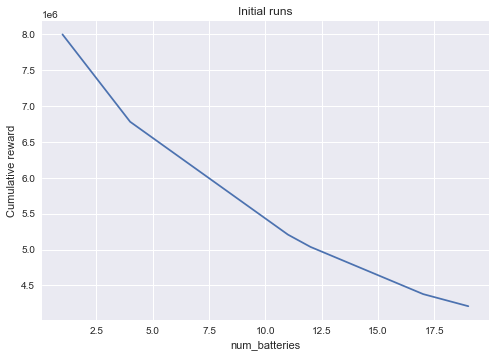

In [16]:
plt.plot(new_X, new_Y)
plt.style.use('seaborn')
plt.title("Initial runs")
plt.xlabel(parameter_space.parameters[0].name)
plt.ylabel("Cumulative reward")
plt.show()

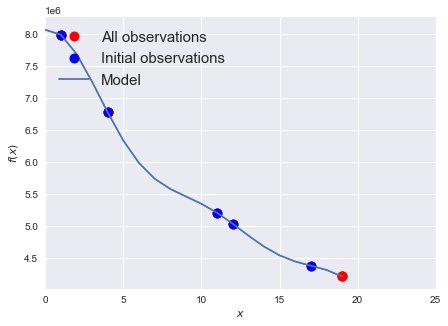

In [17]:
x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
mu_plot, var_plot = model_emukit.predict(x_plot)

# plt.figure(figsize=(12, 8))
plt.figure(figsize=(7, 5))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 25)
plt.show()

In [ ]:
num_tries